In [1]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

# objective function helpers

In [2]:
# functions to identify when prerequisites for tests have been fulfilled
# also converting between the permutation representation and an array representation of the guessed bits

# takes as input a permutation of 128 numbers represting the order of guessing state bits. 
# Outputs an array (step#,bit#) indicating which bits have been selected so far at each step.
def construct_A(L, N=None):
    L = np.array(L)
    M = len(L)
    # Infer N if not provided.
    if N is None:
        N = M
    elif N < M:
        raise ValueError("N must be greater than or equal to the length of L.")
    
    # Initialize an (M, N) binary array with zeros.
    A = np.zeros((M, N), dtype=int)
    
    # Create a mask of shape (M, M) where, for each row r, the first r+1 positions are True.
    # This mask identifies the indices from L that should be used for each row.
    mask = np.arange(M) <= np.arange(M)[:, None]
    rows, pos = np.where(mask)  # rows indices and positions in L
    
    # Use the positions from L to determine the column indices.
    cols = L[pos]
    
    # Set the corresponding entries in A to 1.
    A[rows, cols] = 1
    
    return A

# inverse function
def A_to_perm(A):
    return np.argmax(np.diff(A,prepend=0,axis=0),axis=1)

# input A = array (step#,state bit #) which indicated the bits filled in at each step
# input B = array (state bit #, test #) which indicates the presequisites for each test
# output C = array (state#, test#) which tests have met their presequisite conditions so far

def construct_C(A, B):
    # A has shape (X, Y) and B has shape (Y, Z)
    # Compute the number of matching 1's between each row of A and each column of B.
    common = np.dot(A, B)  # Resulting shape is (X, Z)
    
    # Count the number of ones in each column of B.
    B_counts = np.sum(B, axis=0)  # Shape: (Z,)
    
    # For each cell (i, j), if the count of matching ones equals the total ones in B[:, j],
    # then every 1 in the column B[:, j] appears in A[i, :].
    C = (common == B_counts).astype(np.int64)
    
    return C

# objective functions

we want to minimize score_guessorder()

In [3]:
# the functions to optimize

# input V = length 128 binary vector of the input bits guessed so far
# output = bits of disparity at that point in the process

def f_to_optimize(V):
    tests_achieved = construct_C(V,test_prereqs_trim)
    return sum(V) - tests_achieved @ testinfos_trim

# input guessorder = permutation
# output = maximum bits of disparity at any point

def score_guessorder(guessorder):
    cumulativeguessed = construct_A(guessorder)
    return max([f_to_optimize(V) for V in cumulativeguessed])

testinfos_trim = pickle.load(open('testinfos_trim.pkl','rb'))
test_prereqs_trim = pickle.load(open('test_prereqs_trim.pkl','rb'))

testinfos_trim.shape,test_prereqs_trim.shape

((652,), (128, 652))

# my optimization code

In [4]:
# Optimization code below here
# it works by optimizing the known information at a single point in the process
# I chose 90 bits / 128 because that is around where maximum disparity occurs
# then once we know which 90/128 bits to chose first, we work forward/backward to fill out the rest of the guess order
# when then double-check the true score of the overall order in case the maximum wasn't quite at index 90

In [5]:
# fuctions bool_array_to_int, int_to_bool_array, random_multi_swap, optimize_binary_vector are some optimization code
# credit to chatgpt

def bool_array_to_int(arr):
    """
    Convert a length-128 binary (0/1) array to an integer.
    Using Python’s built-in int avoids overflow since Python ints
    are of arbitrary precision.
    """
    key = 0
    for bit in arr:
        key = (key << 1) | int(bit)
    return key

def int_to_bool_array(x):
    """
    Convert an integer to a 128-length array of 0/1 bits.
    """
    out = np.zeros(128, dtype=np.uint8)
    for i in range(127, -1, -1):
        out[i] = x & 1
        x >>= 1
    return out

def random_multi_swap(current, n_swap):
    """
    Perform a random multi-swap of size n_swap:
    - Randomly pick n_swap positions of '1's and n_swap positions of '0's
      and swap them, preserving the total number of ones.
    """
    newV = current.copy()
    ones_idx = np.flatnonzero(current)
    zeros_idx = np.flatnonzero(current == 0)

    if len(ones_idx) < n_swap or len(zeros_idx) < n_swap:
        return newV

    chosen_ones = np.random.choice(ones_idx, size=n_swap, replace=False)
    chosen_zeros = np.random.choice(zeros_idx, size=n_swap, replace=False)

    newV[chosen_ones] = 0
    newV[chosen_zeros] = 1

    return newV

def optimize_binary_vector(f, initial_V, max_evals):
    """
    Perform a local-search + adaptive multi-swap escape to maximize f(V).
    V must be a length-128 array with exactly 80 bits set to 1.

    :param f:         Black-box objective function f(V: np.ndarray) -> float
    :param initial_V: Initial guess, a 128-length array with sum == 80
    :param max_evals: Maximum number of function evaluations
    :return:          The best 128-bit vector (np.ndarray) found
    """
    V = np.array(initial_V, dtype=np.uint8)
    if V.shape[0] != 128:# or V.sum() != 80:
        raise ValueError("initial_V must be length 128 with exactly 80 ones.")

    # Cache computed objective values: key (int) -> score (float)
    cache = {}
    def get_score(vec):
        key = bool_array_to_int(vec)
        if key not in cache:
            cache[key] = f(vec)
        return cache[key]

    bestV = V.copy()
    best_score = get_score(bestV)
    eval_count = 1

    # Adaptive multi-swap parameter
    multi_swap_size = 2
    no_improvement_streak = 0

    while eval_count < max_evals:
        improved = False

        # Indices of ones and zeros
        ones_idx = np.flatnonzero(bestV)
        zeros_idx = np.flatnonzero(bestV == 0)

        # Shuffle indices for randomized exploration.
        np.random.shuffle(ones_idx)
        np.random.shuffle(zeros_idx)

        for i in range(len(ones_idx)):
            if eval_count >= max_evals:
                break
            for j in range(len(zeros_idx)):
                if eval_count >= max_evals:
                    break

                newV = bestV.copy()
                newV[ones_idx[i]] = 0
                newV[zeros_idx[j]] = 1

                neighbor_score = get_score(newV)
                eval_count += 1

                if neighbor_score < best_score:
                    bestV = newV
                    best_score = neighbor_score
                    improved = True
                    break  # Accept the first improvement found.
            if improved or eval_count >= max_evals:
                break

        if improved:
            no_improvement_streak = 0
            continue

        # If no single-swap improvement was found, attempt a random multi-swap.
        newV = random_multi_swap(bestV, multi_swap_size)
        new_score = get_score(newV)
        eval_count += 1

        if new_score < best_score:
            bestV = newV
            best_score = new_score
            no_improvement_streak = 0
        else:
            no_improvement_streak += 1
            # Increase multi-swap size adaptively if stuck.
            if no_improvement_streak % 3 == 0:
                multi_swap_size = min(multi_swap_size + 1, 10)

    return bestV

In [6]:
# imagine that we have a vector V that represents the number of bits guessed at some point
# in other words, V is a single row from a matrix A
# instead of optimizing the permutation, we can optimize V
# then we can fill out the rest of the rows of A in a greedy manner

def greedy_from_intermediate_slice(V, f_to_optimize):
    """
    Given a binary vector V (NumPy array) and a scoring function f_to_optimize,
    returns an M x M NumPy array where each row is a vector in the greedy sequence.
    
    The sequence is constructed by:
      1. Shrinking: Starting from V (with N ones), at each step flip a 1 to 0
         (choosing the bit whose removal maximizes the score) until only one 1 remains.
      2. Growing: Starting from V, at each step flip a 0 to 1
         (choosing the bit whose addition maximizes the score) until all bits are 1.
      3. Merging: The reversed shrinking sequence (which goes from one 1 up to V)
         is concatenated with the growing sequence (omitting the duplicate V).
    
    In the final M x M array:
      - The first row contains exactly one 1.
      - The Nth row (1-indexed) corresponds to the original vector V.
      - The last row contains all 1s.
    
    Parameters:
    -----------
    V : np.ndarray
        A 1D binary NumPy array of length M.
    f_to_optimize : callable
        A function that takes a binary vector (NumPy array) and returns a score (float).
    
    Returns:
    --------
    np.ndarray
        An M x M array where each row is a binary vector from the optimized sequence.
    """
    M = len(V)
    N = int(np.sum(V))  # number of ones in V
    
    # --- Shrinking sequence: from V (with N ones) down to a vector with a single 1.
    shrinking_sequence = [V.copy()]
    current = V.copy()
    
    # Continue until only one 1 remains.
    while np.sum(current) > 1:
        best_score = np.inf
        best_candidate = None
        # Look at indices where current is 1.
        ones_indices = np.where(current == 1)[0]
        for idx in ones_indices:
            candidate = current.copy()
            candidate[idx] = 0
            score = f_to_optimize(candidate)
            if score < best_score:
                best_score = score
                best_candidate = candidate
        current = best_candidate
        shrinking_sequence.append(current.copy())
    
    # Reverse the shrinking sequence so that it goes from a vector with one 1 up to V.
    shrinking_sequence_reversed = shrinking_sequence[::-1]
    
    # --- Growing sequence: from V (with N ones) up to full ones (M ones).
    growing_sequence = [V.copy()]
    current = V.copy()
    
    # Continue until all bits are 1.
    while np.sum(current) < M:
        best_score = np.inf
        best_candidate = None
        # Look at indices where current is 0.
        zeros_indices = np.where(current == 0)[0]
        for idx in zeros_indices:
            candidate = current.copy()
            candidate[idx] = 1
            score = f_to_optimize(candidate)
            if score < best_score:
                best_score = score
                best_candidate = candidate
        current = best_candidate
        growing_sequence.append(current.copy())
    
    # --- Merge sequences.
    # The reversed shrinking sequence gives vectors with counts: 1, 2, ..., N.
    # The growing sequence gives vectors with counts: N, N+1, ..., M.
    # Omit the first element of growing_sequence (which is V) to avoid duplication.
    merged_sequence = shrinking_sequence_reversed + growing_sequence[1:]
    
    # Verify that the merged sequence has exactly M rows.
    if len(merged_sequence) != M:
        raise ValueError(f"Expected merged sequence of length {M}, got {len(merged_sequence)}.")
    
    # Convert list of vectors into an M x M NumPy array.
    result = np.array(merged_sequence)
    return result

In [7]:
initial_guessperms = pickle.load(open('initial_guessperms.pkl','rb'))
len(initial_guessperms)

19

In [8]:
bestperm = None
bestpermscore = 1000
for i in tqdm(range(10)):
    for initial_guessperm in initial_guessperms:
        initialV = construct_A(initial_guessperm)[90]
        V = optimize_binary_vector(f_to_optimize, initialV, 1000)
        A = greedy_from_intermediate_slice(V, f_to_optimize)
        perm = A_to_perm(A)
        permscore = score_guessorder(perm)
        if permscore < bestpermscore:
            bestpermscore = permscore
            bestperm = perm

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.82s/it]


In [9]:
bestpermscore

np.float64(48.5162842794972)

In [10]:
bestperm

array([126,  62,  45, 127,  63,  46, 125,  61,  44, 124,  60,  43, 123,
        59,  42, 108,  27, 107,  26, 106,  25, 109,  28, 110,  29,  90,
        47,  30,  91,  48,  31,  89,  88,  24,  87,  23, 122,  58,  41,
       105,  86,  22, 111, 112, 121,  57,  40, 104,  85,  21,  93,  12,
        92,  11,  10,   9,   8,   7,   6,   5,   4,  72,  71,  70,  69,
        68, 103,  39, 120,  56,  84,  20,   3,  67,  52,  53,  54,  55,
        73,  74,  51,  50, 113,  49,  13,  94,  75, 114,  14, 115, 116,
        32,  33,  76,  15,  95,  96,  16,  97, 117, 118, 119,  38, 102,
        37, 101,  36,  35,  34, 100,  19,  83,   2,  66,  98,  77,  99,
        78,  17,  18,  79,  80,  81,  82,   1,   0,  65,  64])

# Some plots

In [11]:
cumulativeguessed = construct_A(bestperm)
tests_achieved = construct_C(cumulativeguessed,test_prereqs_trim)
test_points = np.diff(tests_achieved,axis=0,prepend=0)

Text(0.5, 1.0, 'bits guessed - bits of constraint')

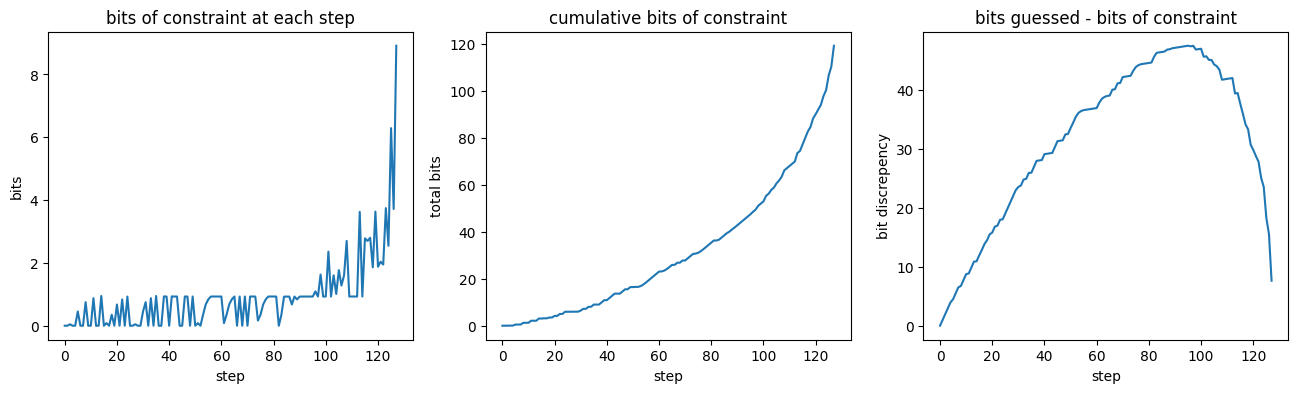

In [12]:
fig,axs = plt.subplots(1,3,figsize=(16,4))

ax=axs[0]
ax.plot(test_points @ testinfos_trim)
ax.set_xlabel("step")
ax.set_ylabel("bits")
ax.set_title("bits of constraint at each step")

ax=axs[1]
ax.plot(np.cumsum(test_points @ testinfos_trim))
ax.set_xlabel("step")
ax.set_ylabel("total bits")
ax.set_title("cumulative bits of constraint")

ax=axs[2]
ax.plot(np.arange(128)-np.cumsum(test_points @ testinfos_trim))
ax.set_xlabel("step")
ax.set_ylabel("bit discrepency")
ax.set_title("bits guessed - bits of constraint")

In [13]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, tdim=100):
    """
    Truncate a colormap by taking a segment between minval and maxval.

    Parameters:
        cmap : matplotlib colormap
            Original colormap to be truncated.
        minval : float, default 0.0
            Minimum value to start truncating.
        maxval : float, default 1.0
            Maximum value for truncation.
        tdim : int, default 100
            Number of discrete colors to generate.

    Returns:
        new_cmap : matplotlib colormap
            The truncated colormap.
    """
    truncated_name = f"trunc({cmap.name},{minval:.2f},{maxval:.2f})"
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        truncated_name,
        cmap(np.linspace(minval, maxval, tdim))
    )
    return new_cmap


def calc_norm_limits(low, high):
    """
    Calculate normalized limits for color mapping.

    The function scales the input values so that the maximum absolute value is normalized
    to 1, then adjusts the range to [0, 1].

    Parameters:
        low : float
            Lower bound value.
        high : float
            Upper bound value.

    Returns:
        norm_low, norm_high : tuple of floats
            Normalized lower and upper limits.
    """
    # Ensure that low is no more than 0 and high is no less than 0
    low = min(low, 0)
    high = max(high, 0)

    # Normalize by the maximum absolute value
    scale_factor = max(abs(np.array([low, high])))
    norm_low = low / scale_factor
    norm_high = high / scale_factor

    # Shift and scale to [0, 1]
    norm_low = norm_low / 2 + 0.5
    norm_high = norm_high / 2 + 0.5

    return norm_low, norm_high


def pltimshow(imshowdata, vmin=None, vmax=None, fig=None, ax=None, **kwargs):
    """
    Display an image using imshow with a truncated colormap and an attached colorbar.

    Parameters:
        imshowdata : array-like
            Image data to be displayed.
        vmin : float, optional
            Minimum data value for colormap scaling.
        vmax : float, optional
            Maximum data value for colormap scaling.
        fig : matplotlib Figure, optional
            Figure object; required if ax is provided.
        ax : matplotlib Axes, optional
            Axes object on which to draw the image.
        **kwargs : dict
            Additional keyword arguments passed to plt.imshow() or ax.imshow().
    """
    # Mask invalid values in the image data
    imshowdata = np.ma.masked_invalid(imshowdata)

    # Set color scaling if not provided
    if vmax is None:
        vmax = np.max(imshowdata)
    if vmin is None:
        vmin = np.min(imshowdata)

    # Calculate normalized limits for the colormap
    norm_low, norm_high = calc_norm_limits(vmin, vmax)

    # Get and truncate the colormap
    cmap = mpl.colormaps.get_cmap("PiYG").copy()
    cmap = truncate_colormap(cmap, norm_low, norm_high, tdim=100)
    cmap.set_bad(color='black')

    if ax is None:
        plt.imshow(imshowdata, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        plt.colorbar()
    else:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='10%', pad=0.15)
        im = ax.imshow(imshowdata, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        fig.colorbar(im, cax=cax, orientation='vertical')


In [14]:
def split_sum_rejoin(arr: np.ndarray) -> np.ndarray:
    R, total_columns = arr.shape
    assert total_columns % (64 * 2) == 0, "Invalid shape: total columns should be a multiple of 64*2"
    
    N = total_columns // (64 * 2)  # Infer N from the shape
    
    # Split the array into two halves
    half_size = total_columns // 2
    first_half, second_half = arr[:, :half_size], arr[:, half_size:]
    
    # Reshape each half into (R, N, 64)
    first_half = first_half.reshape(R, N, 64)
    second_half = second_half.reshape(R, N, 64)
    
    # Sum over the N chunks
    first_summed = first_half.sum(axis=1)  # Shape (R, 64)
    second_summed = second_half.sum(axis=1)  # Shape (R, 64)
    
    # Concatenate the results along the last axis
    output = np.concatenate([first_summed, second_summed], axis=1)  # Shape (R, 64*2)
    
    return output

In [15]:
stateprereqs = pickle.load(open('stateprereqs.pkl','rb'))

Text(0.5, 0, 'next state bit')

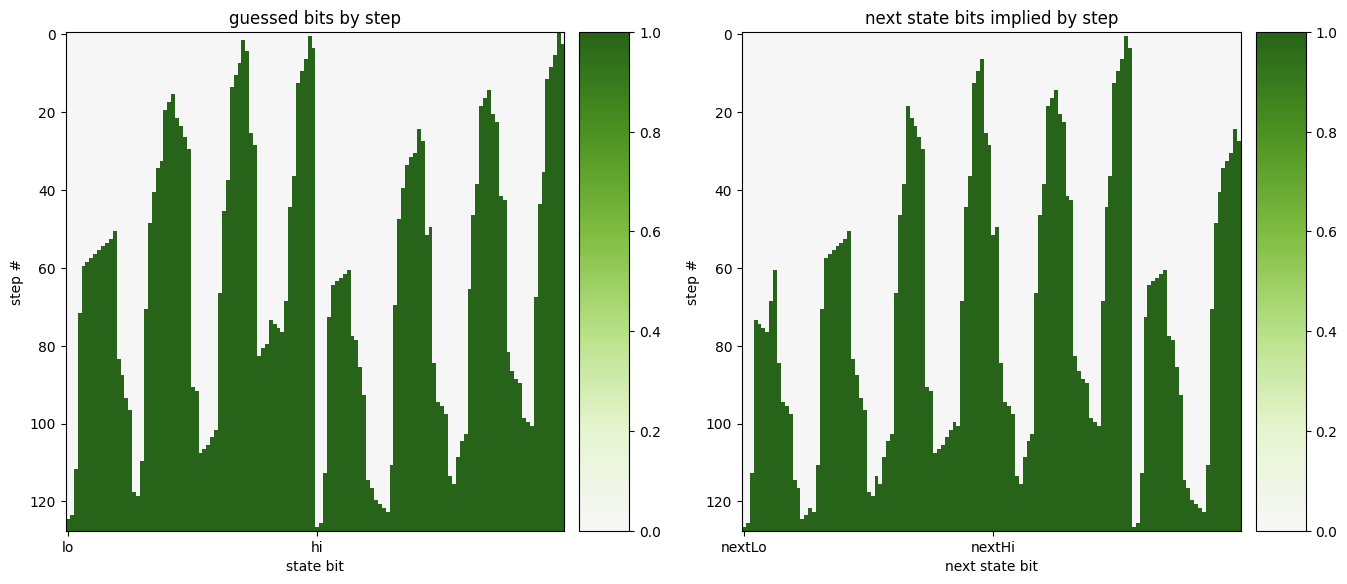

In [16]:
fig,axs = plt.subplots(1,2,figsize=(16,7))

ax =axs[0]
pltimshow(cumulativeguessed,ax=ax,fig=fig)
ax.set_xticks([0,64],['lo','hi'],)
ax.set_title('guessed bits by step')
ax.set_ylabel('step #')
ax.set_xlabel('state bit')

ax = axs[1]
pltimshow(construct_C(cumulativeguessed,stateprereqs),ax=ax,fig=fig)
ax.set_xticks([0,64],['nextLo','nextHi'],)
ax.set_title('next state bits implied by step')
ax.set_ylabel('step #')
ax.set_xlabel('next state bit')